<a href="https://colab.research.google.com/github/bgyarbro/bible-text-generator/blob/master/generator_bible_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re
import os

In [2]:
!wget --no-check-certificate \
  https://raw.githubusercontent.com/bgyarbro/bible-text-generator/master/kjv-1769-clean.txt \
  -O /tmp/kjv-1769-clean.txt

--2020-08-04 14:55:16--  https://raw.githubusercontent.com/bgyarbro/bible-text-generator/master/kjv-1769-clean.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4200408 (4.0M) [text/plain]
Saving to: ‘/tmp/kjv-1769-clean.txt’

/tmp/kjv-1769-clean 100%[===================>]   4.00M  17.5MB/s    in 0.2s    

2020-08-04 14:55:17 (17.5 MB/s) - ‘/tmp/kjv-1769-clean.txt’ saved [4200408/4200408]



In [3]:
# reading Bible from file

lines = []
file = open("/tmp/kjv-1769-clean.txt")
lines.append(file.read())

In [4]:
lines_split = lines[0].split("\n")

In [5]:
lines_split[0:5]

['"\'\'"',
 '"In the beginning God created the heaven and the earth."',
 '"And the earth was without form, and void; and darkness was upon the face of the deep. And the Spirit of God moved upon the face of the waters."',
 '"And God said, Let there be light: and there was light."',
 '"And God saw the light, that it was good: and God divided the light from the darkness."']

In [6]:
lines = pd.DataFrame(lines_split, columns=['lines'])

In [7]:
lines.head()

,lines
0,"""''"""
1,"""In the beginning God created the heaven and t..."
2,"""And the earth was without form, and void; and..."
3,"""And God said, Let there be light: and there w..."
4,"""And God saw the light, that it was good: and ..."


In [8]:
lines = lines[lines.lines != '"\'\'"']

In [9]:
lines.head()

,lines
1,"""In the beginning God created the heaven and t..."
2,"""And the earth was without form, and void; and..."
3,"""And God said, Let there be light: and there w..."
4,"""And God saw the light, that it was good: and ..."
5,"""And God called the light Day, and the darknes..."


In [10]:
def clean_text(sentence):
    sentence = sentence.lower()
    
    sentence = re.sub("\n", "", sentence)

    sentence = re.sub("[-*/()\"’'#/@;:<>{}`+=~|.!?,]", "", sentence)
    
    return sentence

In [11]:
lines.lines = lines.lines.apply(lambda line: clean_text(line))

In [12]:
lines.head()

,lines
1,in the beginning god created the heaven and th...
2,and the earth was without form and void and da...
3,and god said let there be light and there was ...
4,and god saw the light that it was good and god...
5,and god called the light day and the darkness ...


In [13]:
lines.shape

(31102, 1)

In [14]:
lines.lines = lines.lines.apply(lambda line: line.split())

In [15]:
x_train = [line[:-1] for line in lines.lines]
y_train = [line[1:] for line in lines.lines]

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
tokenizer = Tokenizer()

In [18]:
tokenizer.fit_on_texts(lines.lines)

In [19]:
x_train = tokenizer.texts_to_sequences(x_train)
y_train = tokenizer.texts_to_sequences(y_train)

In [20]:
word2idx = tokenizer.word_index
idx2word = {value: key for key, value in word2idx.items()}

In [21]:
word2idx["<pad>"] = 0
idx2word[0] = "<pad>"

In [22]:
lengths = []

for sequence in x_train:
    lengths.append(len(sequence))
    
lengths = pd.Series(lengths)
lengths.describe()

count    31102.000000
mean        24.387885
std         11.079740
min          1.000000
25%         16.000000
50%         23.000000
75%         31.000000
max         89.000000
dtype: float64

In [23]:
maxlen = 90
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 1024
vocab_size

12693

In [24]:
x_train = pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
y_train = pad_sequences(y_train, maxlen=maxlen, padding='post', truncating='post')

In [25]:
print(x_train.shape)
print(y_train.shape)
print(x_train[0])
print(y_train[0])

(31102, 90)
(31102, 90)
[   6    1  678   27 1301    1  172    2    1    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
[   1  678   27 1301    1  172    2    1  110    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


In [26]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, Dense, Input, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [27]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True))
model.add(GRU(units=1024, return_sequences=True))
model.add(Dense(vocab_size))

In [28]:
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [29]:
history = model.fit(x_train, y_train, epochs=10, verbose=1)

Epoch 1/10
972/972 [==============================] - 190s 195ms/step - loss: 1.3231 - accuracy: 0.2092
Epoch 2/10
972/972 [==============================] - 190s 195ms/step - loss: 1.0506 - accuracy: 0.2818
Epoch 3/10
972/972 [==============================] - 190s 195ms/step - loss: 0.9036 - accuracy: 0.3279
Epoch 4/10
972/972 [==============================] - 189s 195ms/step - loss: 0.7768 - accuracy: 0.3824
Epoch 5/10
972/972 [==============================] - 189s 194ms/step - loss: 0.6698 - accuracy: 0.4435
Epoch 6/10
972/972 [==============================] - 189s 194ms/step - loss: 0.5823 - accuracy: 0.5016
Epoch 7/10
972/972 [==============================] - 189s 194ms/step - loss: 0.5099 - accuracy: 0.5535
Epoch 8/10
972/972 [==============================] - 188s 194ms/step - loss: 0.4513 - accuracy: 0.5990
Epoch 9/10
972/972 [==============================] - 189s 195ms/step - loss: 0.4038 - accuracy: 0.6376
Epoch 10/10
972/972 [==============================] - 193s 198m

In [ ]:
#model.save("model.h5")
#model = load_model("model.h5")

In [30]:
def generate(word):
    word = clean_text(word)
    inputs = np.zeros((1, 1))
    inputs[0, 0] = word2idx[word]
    count = 1
    while count <= 100:
        pred = model.predict(inputs)
        word = np.argmax(pred)
        if word >= vocab_size:
            word = vocab_size - 1

        inputs[0, 0] = word
        
        print(idx2word[word], end=" ")
        count += 1


In [35]:
generate("god")

reigneth over against whom i will he that the lord thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt 

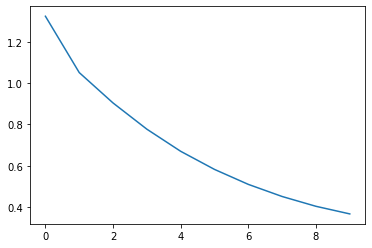

In [33]:
import matplotlib.pyplot as plt

plt.plot(range(10), history.history['loss'])